In [0]:
import keras

from keras.preprocessing.image import load_img, img_to_array

target_image_path = 'content.jpg'
style_reference_image_path = 'style.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(img_height * width / height)

In [0]:
from keras.applications import vgg19

import numpy as np

def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
  # Remove zero-center by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # 'BGR' -> 'RGB'
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [4]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_width, img_height, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                   include_top=False,
                   weights='imagenet')

print('Model Loaded')

Model Loaded


In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

def gram_matrix(x):
  # (H,W,C) -> (C, H*W)
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  # Outputs (C, C)
  gram = K.dot(features, K.transpose(features))
  return gram
  
def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))  

def total_variation_loss(x):
  a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1,:])
  b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

content_weight = 0.025
style_weight = 1
total_variation_weight = 1e-4

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_features, combination_features)

for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_features, combination_features)
  loss += (style_weight / len(style_layers)) * sl

loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        #assert self.loss_value is None
        print("Computing Loss")
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        #assert self.loss_value is not None
        print("Computing Gradients")
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [13]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                   fprime=evaluator.grads, maxfun=2)
  print('Current loss value:', min_val)
  
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_iteration_%d_.png' % i
  imsave(fname, img)
  end_time = time.time()
  print('Image saved as', fname)
  print('Iteration %d completed in %ds' % (i, end_time - start_time))
  


Start of iteration 0
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Current loss value: 48807436000.0
Image saved as style_transfer_result_iteration_0_.png
Iteration 0 completed in 107s
Start of iteration 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Current loss value: 39773004000.0
Image saved as style_transfer_result_iteration_1_.png
Iteration 1 completed in 107s
Start of iteration 2
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Current loss value: 32454490000.0
Image saved as style_transfer_result_iteration_2_.png
Iteration 2 completed in 108s
Start of iteration 3
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Computing Loss
Computing Gradients
Current loss value: 26579798000.0
Image saved as style_transfer_result_iteration_3_.png
Iter

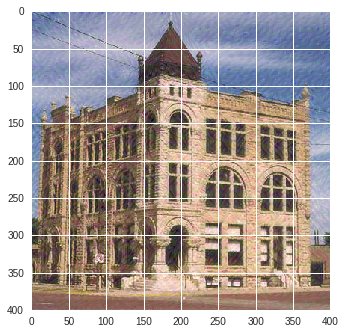

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fname = 'style_transfer_result_iteration_19_.png'

img = mpimg.imread(fname)
plt.imshow(img)
plt.show()